In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
df = pd.read_csv('./AUD_USD Historical Data.csv')
df.head()

,Date,Price,Open,High,Low,Change %
0,"Sep 25, 2000",0.5490,0.5486,0.5507,0.5429,0.86%
1,"Sep 26, 2000",0.5488,0.5448,0.5518,0.5448,-0.04%
2,"Sep 27, 2000",0.5510,0.5505,0.5518,0.5468,0.40%
3,"Sep 28, 2000",0.5443,0.5508,0.5514,0.5437,-1.22%
4,"Sep 29, 2000",0.5428,0.5439,0.5452,0.5386,-0.28%


In [148]:
df['Date']=pd.to_datetime(df['Date'])
df_idx = df.set_index(['Date'], drop=True)
df_idx.tail()

,Price,Open,High,Low,Change %
Date,,,,,
2018-09-19,0.7264,0.7218,0.7276,0.7211,0.62%
2018-09-20,0.7291,0.7264,0.7295,0.7254,0.37%
2018-09-21,0.7291,0.7294,0.7307,0.7262,0.00%
2018-09-23,0.7277,0.7263,0.7278,0.7263,-0.19%
2018-09-24,0.7260,0.7277,0.7281,0.7253,-0.23%


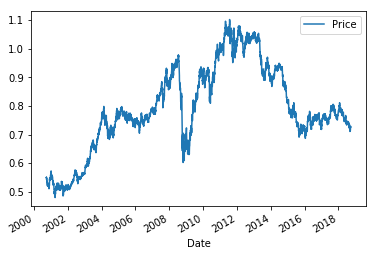

In [149]:
data = df_idx[['Price']]
data.plot(y='Price')

In [150]:
diff = data.index.values[-1]-data.index.values[0]
days = diff.astype('timedelta64[D]')
days /= np.timedelta64(1, 'D')
years = int(days/365)
print('Total data %d years' %years)
print('80 percent data =  2000 to %d' %(2000+int(0.8*years)))

Total data 18 years
80 percent data =  2000 to 2014


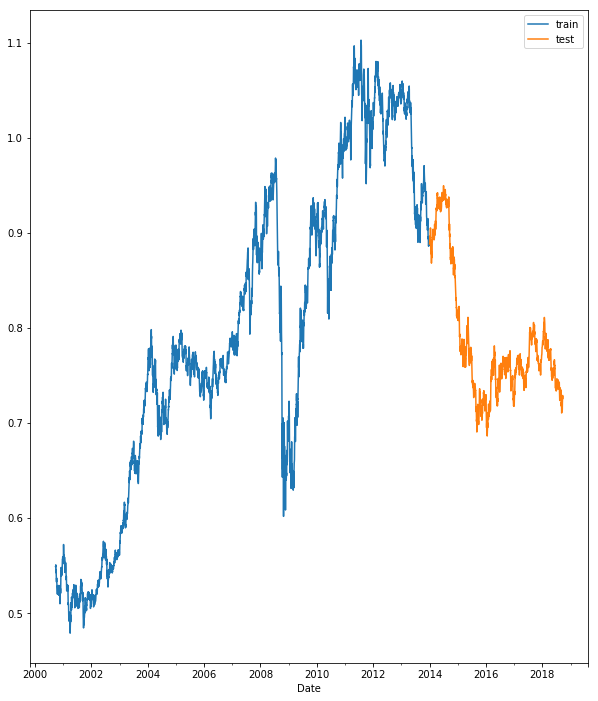

In [151]:
split_date = pd.Timestamp('01-01-2014')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [152]:
from sklearn.preprocessing import MinMaxScaler

In [153]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

In [154]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index = train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index = test.index)

In [155]:
for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

In [156]:
X_train_df = train_sc_df.dropna().drop('Y', axis=1)
Y_train_df = train_sc_df.dropna().drop('X_1', axis=1)

X_test_df = test_sc_df.dropna().drop('Y', axis=1)
Y_test_df = test_sc_df.dropna().drop('X_1', axis=1)

X_test_df.tail()

X_train = X_train_df.values
Y_train = Y_train_df.values

X_test = X_test_df.values
Y_test = Y_test_df.values

In [157]:
print('Train size:', X_train.shape)
print('test size:', X_test.shape)

Train size: (3462, 1)
test size: (1250, 1)


In [158]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [159]:
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

/Users/Luchuchu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


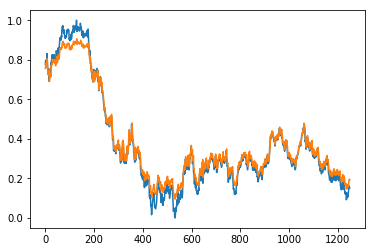

In [160]:
plt.plot(Y_test)
plt.plot(y_pred)

In [161]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*(n-1)/(n-k-1))

r2_test = r2_score(Y_test, y_pred)
adj_r2_test = adj_r2_score(r2_test, len(X_train), len(X_test))
print(r2_test, adj_r2_test)

0.9803495279152291 0.969240034425422


In [162]:
sc.inverse_transform(y_pred[-1])

array([[0.73690437]])

In [163]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

In [164]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
3462/3462 [==============================] - 0s - loss: 0.5056     
Epoch 2/20
3462/3462 [==============================] - 0s - loss: 0.2257     
Epoch 3/20
3462/3462 [==============================] - 0s - loss: 0.1150     
Epoch 4/20
3462/3462 [==============================] - 0s - loss: 0.0784     
Epoch 5/20
3462/3462 [==============================] - 0s - loss: 0.0650     
Epoch 6/20
3462/3462 [==============================] - 0s - loss: 0.0585     
Epoch 7/20
3462/3462 [==============================] - 0s - loss: 0.0536     
Epoch 8/20
3462/3462 [==============================] - 0s - loss: 0.0490     
Epoch 9/20
3462/3462 [==============================] - 0s - loss: 0.0444     
Epoch 10/20
3462/3462 [==============================] - 0s - loss: 0.0396     
Epoch 11/20
3462/3462 [==============================] - 0s - loss: 0.0349     
Epoch 12/20
3462/3462 [==============================] - 0s - loss: 0.0303     - ETA: 0s - loss:
Epoch 13/20
3462/3462 [=========

0.9070279964590982


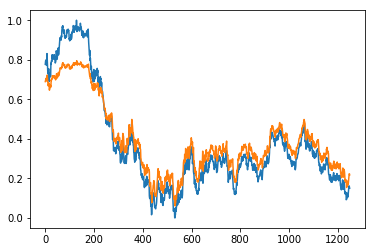

In [165]:
y_pred_keras = model.predict(X_test)
plt.plot(Y_test)
plt.plot(y_pred_keras)
print(r2_score(Y_test, y_pred_keras))

In [167]:
K.clear_session()
model2 = Sequential()
model2.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model2.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model2.fit(X_train, Y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
3462/3462 [==============================] - 0s - loss: 0.0157     
Epoch 2/20
3462/3462 [==============================] - 0s - loss: 1.3027e-04     
Epoch 3/20
3462/3462 [==============================] - 0s - loss: 1.3189e-04     
Epoch 4/20
3462/3462 [==============================] - 0s - loss: 1.3061e-04     
Epoch 5/20
3462/3462 [==============================] - 0s - loss: 1.3018e-04     
Epoch 6/20
3462/3462 [==============================] - 0s - loss: 1.4016e-04     
Epoch 7/20
3462/3462 [==============================] - 0s - loss: 1.3467e-04     
Epoch 8/20
3462/3462 [==============================] - 0s - loss: 1.3645e-04     
Epoch 9/20
3462/3462 [==============================] - 0s - loss: 1.3924e-04     
Epoch 10/20
3462/3462 [==============================] - 0s - loss: 1.2891e-04     
Epoch 11/20
3462/3462 [==============================] - 0s - loss: 1.5182e-04     
Epoch 12/20
3462/3462 [==============================] - 0s - loss: 1.3703e-04     
Epoch

[[0.726]] [[0.7279322]]


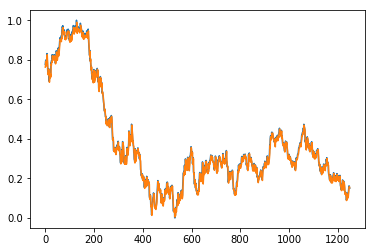

In [173]:
y_pred_keras2 = model2.predict(X_test)
plt.plot(Y_test)
plt.plot(y_pred_keras2)

print(sc.inverse_transform(Y_test[-1][0]), sc.inverse_transform(y_pred_kera2[-1][0]))